In [1]:
''' 
Jupyter notebook version of the toy network consisting of a 2-in-2-out junction.
'''
### Import relevant modules
import sys
from pathlib import Path

# add parent directory to Python path
sys.path.append(str(Path().resolve().parent))

from road import Road
from junction import Junction
from network import Network
import optimization_script_parallel

import matplotlib.pyplot as plt
import numpy as np

In [74]:
### Setup the toy network

# Set global parameters for the roads
Road.dt = 0.1 # time step in seconds
Road.p_j = 200 # jam density in vehicles per mile

# Create 4 roads in the network
entry = Road('entry')
road2 = Road('upper road 1')
road3 = Road('upper road 2')
road4 = Road('lower road')
exit = Road('exit')

# Set parameters for the roads
entry.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=.9)
entry.set_left_boundary_function(lambda time,sig: 0.9) # constant inflow of 0.9 vehicles per second

road2.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=0)
road3.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=0)

road4.set_params(speed=20,lanes=1,length=1,cap=500,init_density_factor=0)

exit.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=0)
exit.set_right_boundary_function(lambda time,sig: 0) # free outflow


# Create a junction connecting the roads
junction1 = Junction('1-in-2-out')
junction1.set_roads_in(entry).set_roads_out(road2, road4)

junction2 = Junction('1-in-1-out')
junction2.set_roads_in(road2).set_roads_out(road3)

junction3 = Junction('2-in-1-out')
junction3.set_roads_in(road3, road4).set_roads_out(exit)

# Set exit junction
junction3.set_is_exit_junction()

# Create a network with the junctions
network = Network([junction1, junction2, junction3])

# Set driving preferences for the network
network.set_preferences(network.get_default_preferences())
network.compute_distances(junction3)

{1-in-2-out: 2, 1-in-1-out: 2, 2-in-1-out: 1}

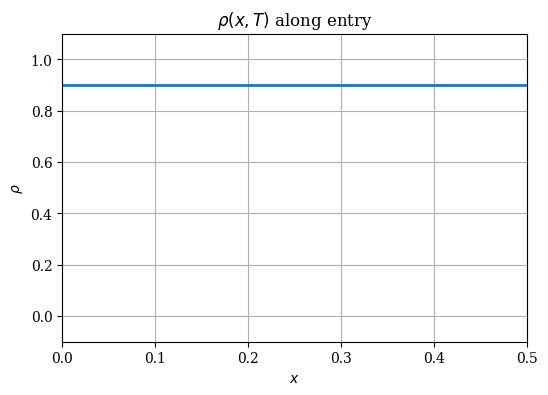

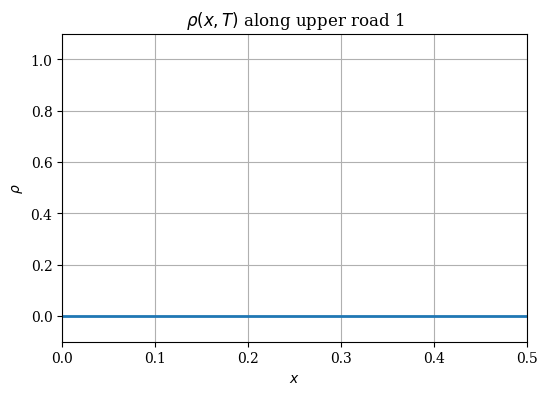

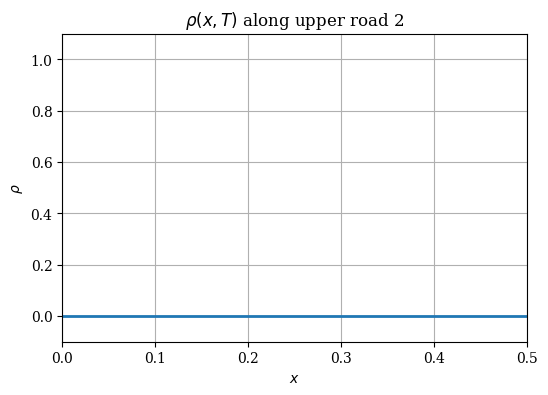

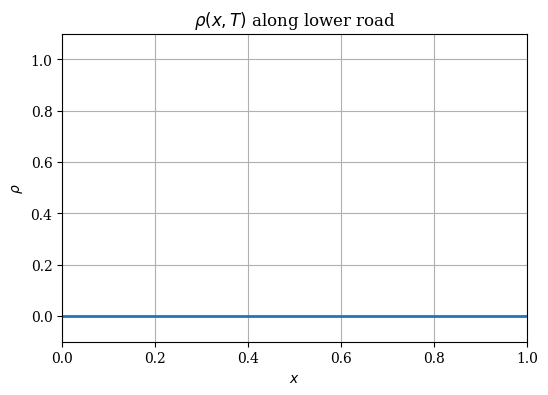

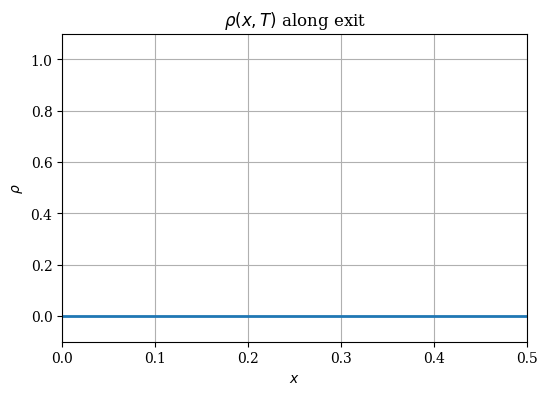

In [75]:
### Plot the roads' initial densities
entry.plot_current_density()
road2.plot_current_density()
road3.plot_current_density()
road4.plot_current_density()
exit.plot_current_density()


In [77]:
# Simulate the network for 1000 time steps
for _ in range(1000):
    network.evolve_resolve(record_densities=True)

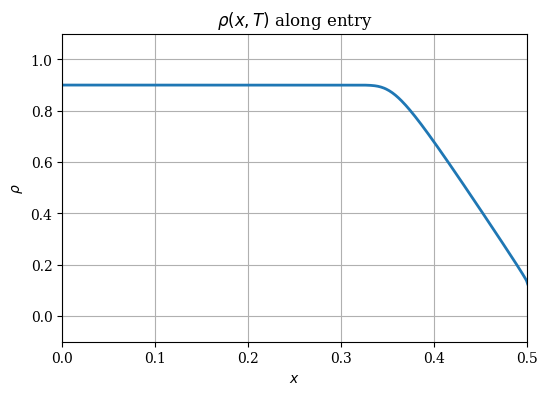

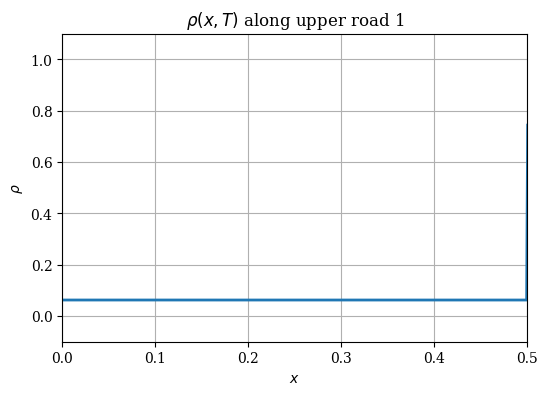

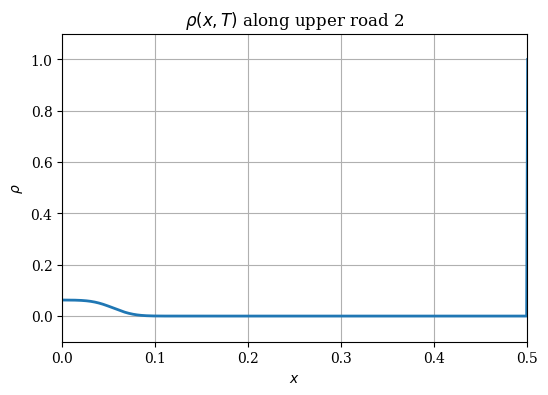

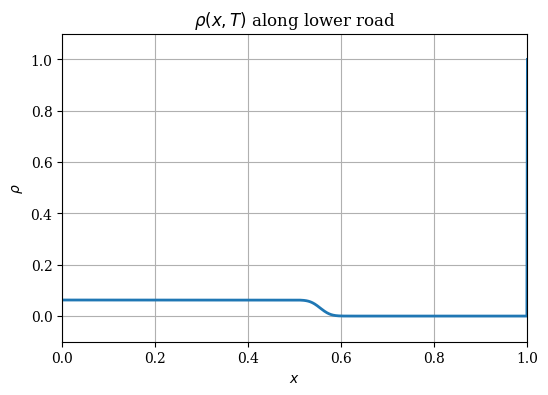

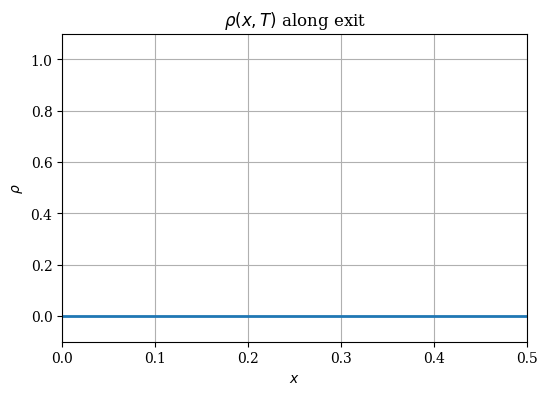

In [78]:
### Plot the roads' initial densities
entry.plot_current_density()
road2.plot_current_density()
road3.plot_current_density()
road4.plot_current_density()
exit.plot_current_density()

In [73]:
# Print metrics for network
weighted_cars = network.get_time_integrated_cars_distance_scaled()
los_count = network.count_roads_per_LOS()
segment_los_count = network.count_segments_per_LOS()
cars_entered = network.get_time_integrated_cars_entered()
cars_exited = network.get_time_integrated_cars_exited()
time_int_cars_exits = network.get_time_integrated_cars_on_exit_roads()
time_int_cars_main = network.get_time_integrated_cars_on_main_roads()

print(f"Weighted cars distance scaled: {weighted_cars}")
print(f"Number of road segments per LOS: {los_count}")
print(f"Number of segments per LOS: {segment_los_count}")
print(f"Cars entered: {cars_entered}")
print(f"Cars exited: {cars_exited}")
print(f"Time-integrated cars on exit roads: {time_int_cars_exits}")
print(f"Time-integrated cars on main roads: {time_int_cars_main}")

Weighted cars distance scaled: 11.875168952491428
Number of road segments per LOS: {'A': 3, 'B': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 0}
Number of segments per LOS: {'A': 3, 'B': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 0}
Cars entered: 13.87799319727918
Cars exited: 0.0
Time-integrated cars on exit roads: 2.843229034342832e-168
Time-integrated cars on main roads: 3.46875


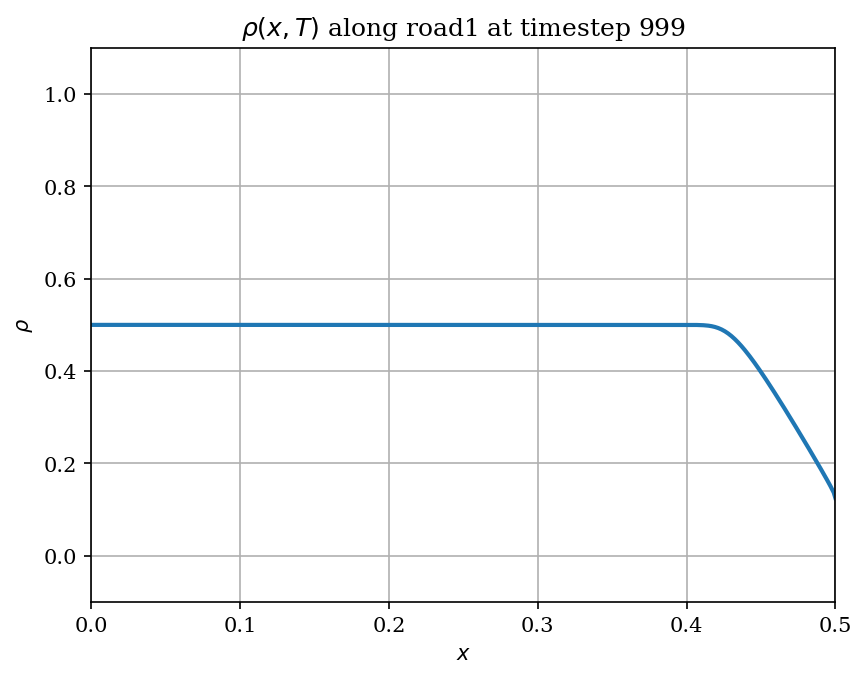

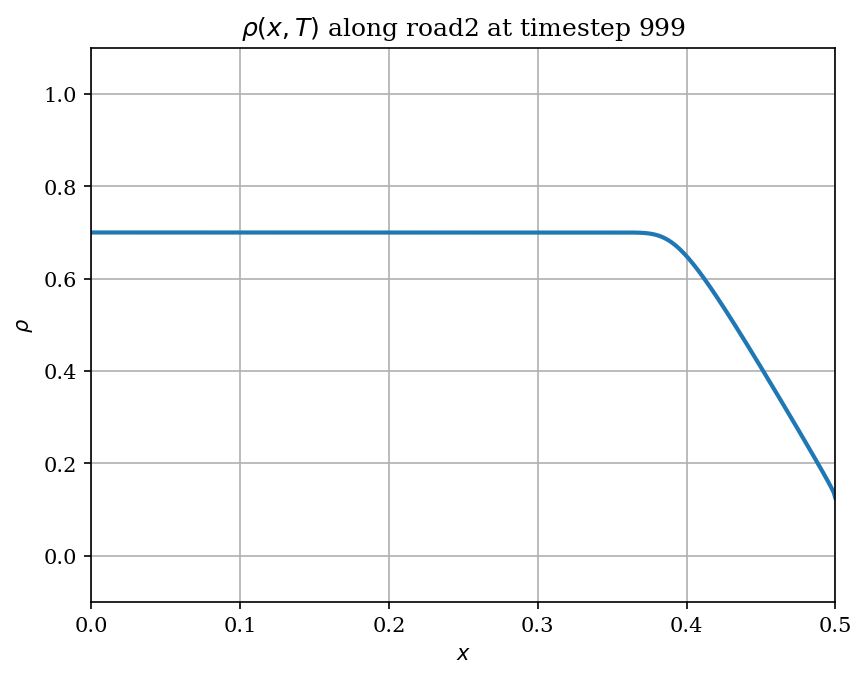

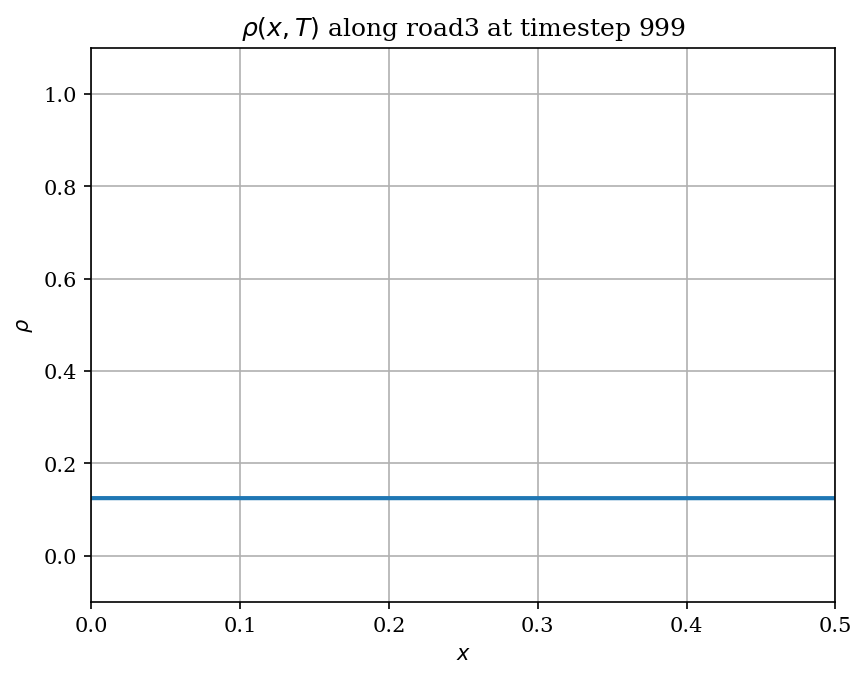

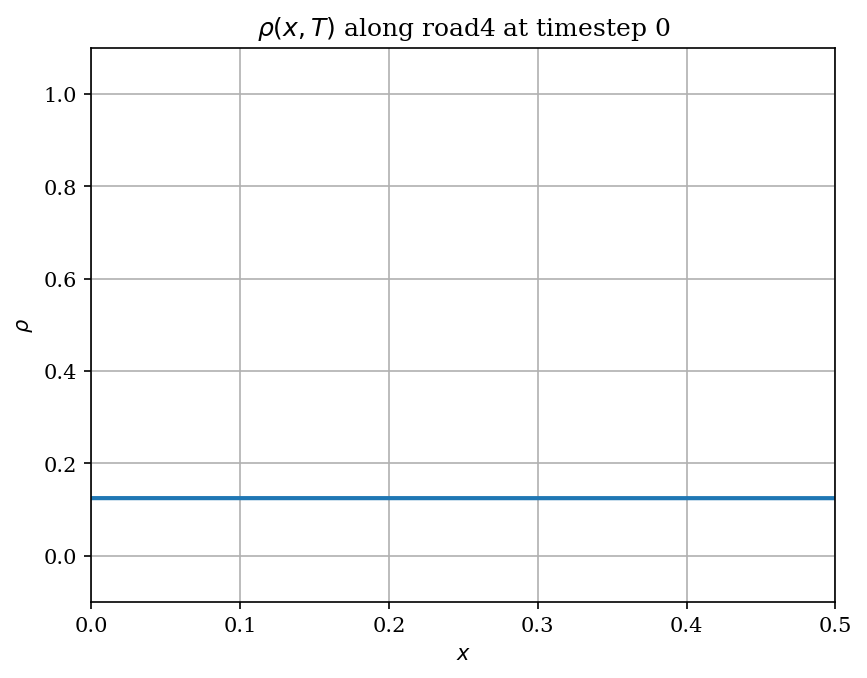

In [ ]:
# Animate the roads' densities over time
entry.animate_density_history("road1_animation.gif")
road2.animate_density_history("road2_animation.gif")
road3.animate_density_history("road3_animation.gif")
exit.animate_density_history("road4_animation.gif")

In [64]:
### Now optimize the junction preferences and re-simulate

network.reset_by_data()  # reset the network to initial conditions

optimization_script_parallel.hyperparameters[-1] = 1  # number of samples for optimization, need to pick 1 here for toy example
optimization_script_parallel.run_optimization(None, network, nt_opt_val=10, output_dir="")
# Optimal parameters will be saved in toy/opt_parameters.txt
network.read_preferences("opt_parameters.txt")

# Simulate the network for 1000 time steps
for _ in range(1000):
    network.evolve_resolve(record_densities=True)

# Animate the road's densities over time
# entry.animate_density_history("road1_animation.gif")
# road2.animate_density_history("road2_animation.gif")
# road3.animate_density_history("road3_animation.gif")
# exit.animate_density_history("road4_animation.gif")

Using 1 processes for parallel gradient computation
Iteration Number: 1 Out of 100
Iteration 1 completed in 0.73 seconds
Iteration Number: 2 Out of 100
Iteration 2 completed in 0.64 seconds
Iteration Number: 3 Out of 100
Iteration 3 completed in 0.62 seconds
Iteration Number: 4 Out of 100
Iteration 4 completed in 0.64 seconds
Iteration Number: 5 Out of 100
Iteration 5 completed in 0.84 seconds
Iteration Number: 6 Out of 100
Iteration 6 completed in 0.72 seconds
Iteration Number: 7 Out of 100
Iteration 7 completed in 0.73 seconds
Iteration Number: 8 Out of 100
Iteration 8 completed in 0.72 seconds
Iteration Number: 9 Out of 100
Iteration 9 completed in 0.75 seconds
Iteration Number: 10 Out of 100
Iteration 10 completed in 0.89 seconds
Iteration Number: 11 Out of 100
Iteration 11 completed in 0.89 seconds
Iteration Number: 12 Out of 100
Iteration 12 completed in 0.78 seconds
Iteration Number: 13 Out of 100
Iteration 13 completed in 0.73 seconds
Iteration Number: 14 Out of 100
Iteration 1

In [65]:
# Print metrics for network
weighted_cars_after = network.get_time_integrated_cars_distance_scaled()
los_count_after = network.count_roads_per_LOS()
segment_los_count_after = network.count_segments_per_LOS()
cars_entered_after = network.get_time_integrated_cars_entered()
cars_exited_after = network.get_time_integrated_cars_exited()
time_int_cars_exits_after = network.get_time_integrated_cars_on_exit_roads()
time_int_cars_main_after = network.get_time_integrated_cars_on_main_roads()

# Print old and new metrics for comparison in nice table
print(f"{'Metric':<50}{'Before Optimization':<30}{'After Optimization':<30}")
print("-" * 110)
print(f"{'Weighted cars distance scaled':<50}{weighted_cars:<30}{weighted_cars_after:<30}")
print(f"{'Number of road segments per LOS':<50}{str(los_count):<30}{str(los_count_after):<30}")
print(f"{'Number of segments per LOS':<50}{str(segment_los_count):<30}{str(segment_los_count_after):<30}")
print(f"{'Cars entered':<50}{cars_entered:<30}{cars_entered_after:<30}")
print(f"{'Cars exited':<50}{cars_exited:<30}{cars_exited_after:<30}")
print(f"{'Time-integrated cars on exit roads':<50}{time_int_cars_exits:<30}{time_int_cars_exits_after:<30}")
print(f"{'Time-integrated cars on main roads':<50}{time_int_cars_main:<30}{time_int_cars_main_after:<30}")

Metric                                            Before Optimization           After Optimization            
--------------------------------------------------------------------------------------------------------------
Weighted cars distance scaled                     11.875168952491428            12.302399839857472            
Number of road segments per LOS                   {'A': 3, 'B': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 0}{'A': 3, 'B': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 0}
Number of segments per LOS                        {'A': 3, 'B': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 0}{'A': 3, 'B': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 0}
Cars entered                                      13.87799319727918             13.87799319727918             
Cars exited                                       0.0                           0.0                           
Time-integrated cars on exit roads                2.843229034342832e-168        2.8432290343428315e-168       
Time-integrated cars on main roads      

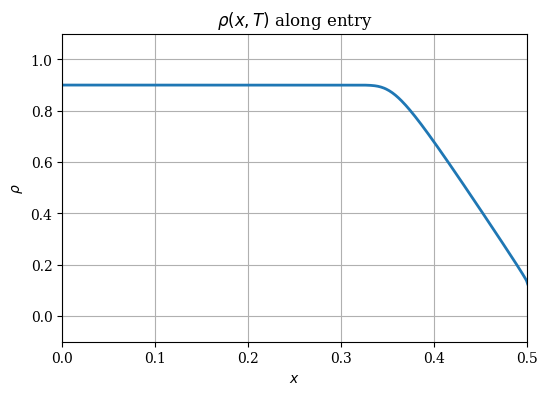

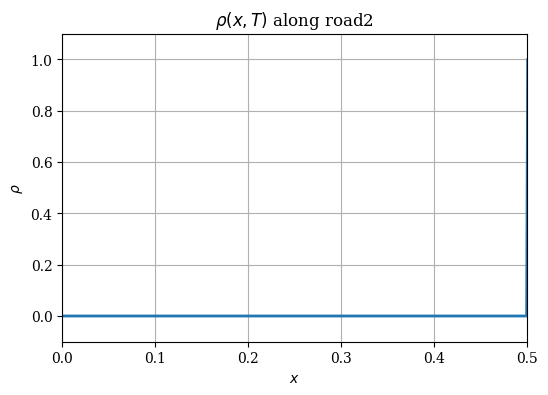

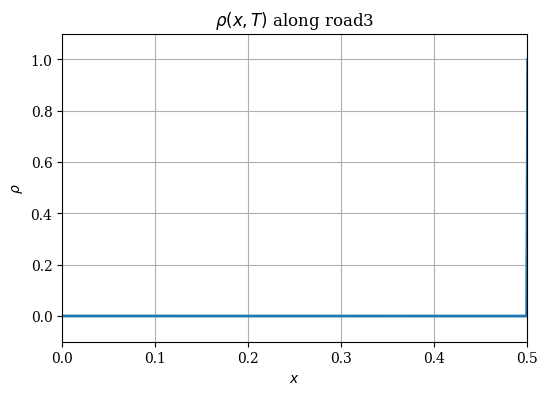

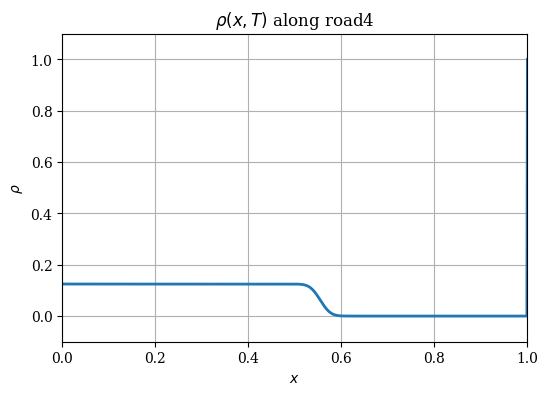

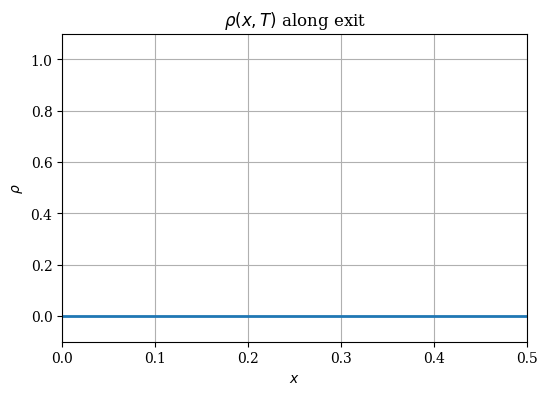

In [67]:
### Plot the roads' initial densities
entry.plot_current_density()
road2.plot_current_density()
road3.plot_current_density()
road4.plot_current_density()
exit.plot_current_density()